# Table of Contents
- [Global Import](#global-import)
    - [Main Functions](#main-functions)
- [Data Preprocessing](#data-preprocessing)    
    - [Unpacking](#unpacking)
        - [`"proj_xz.pkl"`](#proj_xz-pkl)
        - [`"input.dat"`](#input-dat)
    - [Creating Input Dataset](#creating-input-dataset)
        - [Spike Times](#spike-times)
        - [Batches](#batches)
        - [`stim_train`](#stim-train)
            - [Batches vs `stim_train`](#batches-vs-stim)
        - [GID to `xz_array` Index & Creating `x_data`](#creating-x-data)
    - [Error Correction Dataset](#error-correction-dataset)
- [Autoencoder](#autoencoder)
    - [Building](#building)
    - [Training](#training)
        - [Simple Autoencoder](#simple-autoencoder)
            - [Sparse Autoencoder](#sparse-autoencoder)
            - [`batch_size` and Loss](#batch-size-and-loss)
                - [Sparse `adadelda`](#sp-adadelta)
                - [Sparse `adam`](#sp-adam)
                - [Simple `adadelta`](#sl-adadelta)
        - [Low-dimentional Auroencoder](#lim-dim-ae)
        - [Deep Autoencoder](#deep-autoencoder)
        - [Denoising Autoencoder](#denoising-autoencoder)
- [Readout](#readout)
    - [Dataset for Representation Training](#repr_data)
        - [Output](#repr_data_out)
        - [Input](#repr_data_in)
    - [Building](#ro_building)
    - [Training](#ro_training)
        - [On Input](#on-input)
            - [Best Model](#on-input-best)
        - [On Representations](#on-repr)
        - [Comparison](#comparison)
- [Analysis](#analysis)
    - [Analytical Tools Development](#analytical-tools-development)
        - [Comparative Histogram](#comparative-histogram)
        - [Comparative Animation](#comparative-animation)
        - [Working with Patterns](#working-with-patterns)
            - [Pattern Sums](#pattern-sums)
            - [Pattern Distributions](#pattern-sums)
            - [Summary Table](#summary-table)
        - [Dimensional Representation Visualization](#dim-repr-viz)
            - [Example Table](#ex-table)
        - [Weights Visualization](#weights-viz)
        - [Custering Visualization](#clustering-viz)
            - [8D AE Summary Table](#8d-ae-table)
- [Project Log](#project-log)

# Global Import <a class="anchor" id="global-import"></a>

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import colors

import numpy as np
np.set_printoptions(suppress=True)

import pickle as pkl

from keras.models import load_model

Using TensorFlow backend.


## Main Functions <a class="anchor" id="main-functions"></a>

In [2]:
with open('data/input/xz_array.pkl', 'rb') as f:
    xz_array = pkl.load(f)

In [3]:
def plot(data, titles=None, fig_title="", plot_name="title.png", show=False, save=True, ticksize=None, scale_to_01=True):
    if titles == None:
        titles = [""]*len(data)
        
    """Plots valued scatter plots."""
    fig, axs = plt.subplots(1, len(data), sharey=True, figsize=(4*len(data), 4))
    if len(data) == 1:
        axs = [axs]
    
    if scale_to_01:
        norm = colors.Normalize(vmin=0, vmax=1)
    cmap = plt.cm.get_cmap('plasma')
    rgba = cmap(0)

    fig.suptitle(fig_title)
    
    for ax, title in zip(axs, titles):
        ax.set_title(title)
        ax.set(adjustable='box-forced', aspect='equal')
        ax.set_facecolor(rgba)      
    
    images = [axs[i].scatter(xz_array[:, 1], xz_array[:, 2], c=np.zeros(xz_array.shape[0]), s=3, cmap='plasma') \
              for i in range(len(axs))]
    
    cbar = fig.colorbar(images[0], ax=list(axs), orientation='vertical', fraction=.02)
    if ticksize != None:
        cbar.ax.tick_params(labelsize=ticksize)
    
    if len(data[0].shape) == 1:
        for i, im in enumerate(images):
            if not scale_to_01:
                norm = colors.Normalize(vmin=np.min(data[i]), vmax=np.max(data[i]))
            im.set_norm(norm)
            im.set_array(data[i].reshape(-1))
        
        if save == True:
            fig.savefig('data/incite/{}'.format(plot_name), dpi=300)
    else:
        def update(frame):
            for i, im in enumerate(images):
                if not scale_to_01:
                    norm = colors.Normalize(vmin=np.min(data[i]), vmax=np.max(data[i]))
                    im.set_norm(norm)
                im.set_array(data[i][frame])
            return images

        ani = animation.FuncAnimation(fig, update, frames=data[0].shape[0],\
                                      interval=1000, blit=True)
        if save == True:
            ani.save("data/incite/{}.mp4".format(plot_name), dpi=300)
        
    if show == True:
        plt.show()
        
    plt.close('all')

# Data Preprocessing <a class="anchor" id="data-preprocessing"></a>

> Please find attached an exemplar input file for the simulations we are running.

> I also attached a dictionary with the X and Z coordinate of each innervating fiber.

> Stimuli are presented every 200 ms.

## Unpacking <a class="anchor" id="unpacking"></a>
### `"proj_xz.pkl"` <a class="anchor" id="proj_xz-pkl"></a>

In [4]:
with open('data/input/proj_xz.pkl', 'rb') as f:
    xz_glob = pkl.load(f, encoding='latin1')

In [5]:
xz_array = np.zeros((1, 2))
keys = []
for key in xz_glob:
    keys.append(key)
    xz_array = np.concatenate((xz_array, xz_glob[key].reshape((1, 2))), axis=0)
keys = np.array(keys).reshape(-1, 1)
xz_array = np.concatenate((keys, xz_array[1:]), axis=1)

In [6]:
with open('data/input/xz_array.pkl', 'wb') as f:
    pkl.dump(xz_array, f)

In [7]:
# `xz_array` - array of GIDs and their coordinates.
xz_array

array([[221184.   ,    489.488,    591.93 ],
       [221185.   ,    206.701,    563.71 ],
       [221186.   ,    319.906,    457.568],
       ...,
       [221181.   ,    250.45 ,    495.846],
       [221182.   ,    479.566,    650.127],
       [221183.   ,    391.449,    464.526]])

In [8]:
xz_array[np.argwhere(xz_array == 221186)[:, 0], :]

array([[221186.   ,    319.906,    457.568]])

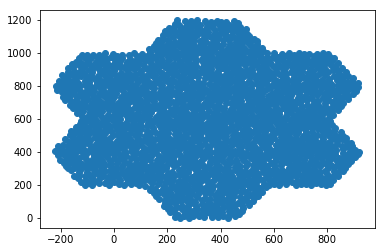

In [9]:
plt.scatter(xz_array[:, 1], xz_array[:, 2]) # background hexagonal structure
plt.show()

### `"input.dat"` <a class="anchor" id="input-dat"></a>
- `"input.dat"` contains spiking times paired with GIDs (global IDs)
- Patterns go in 200 ms packs
- To make pictures, add up activities over each 200 ms

In [10]:
input_ = np.loadtxt('data/input/input.dat', skiprows=1)
input_ = np.flip(input_, axis=1)

In [11]:
print(input_)
print(input_.shape)

[[221184.         1200.406006]
 [221184.         1801.768311]
 [221184.         1864.717529]
 ...
 [221183.        26553.761719]
 [221183.        27957.466797]
 [221183.        29371.466797]]
(77654, 2)


In [12]:
print("Avg fibres per spike time: {}".format(input_.shape[0] / np.unique(input_[:, 1]).shape[0]))

Avg fibres per spike time: 21.685004188774087


## Creating Input Dataset <a class="anchor" id="creating-input-dataset"></a>

### Spike Times <a class="anchor" id="spike-times"></a>

In [13]:
# Take all GIDs for each unique spike time.
times = np.unique(input_[:, 1])
times_ids = [list(input_[:, 0][np.argwhere(input_ == i)[:, 0]]) for i in times]

In [14]:
with open('data/input/times_ids.pkl', 'wb') as f:
    pkl.dump(times_ids, f)

In [15]:
print(*times[:20], sep=', ')

5.929567, 42.251926, 46.631271, 98.360054, 101.799149, 109.969688, 120.498459, 139.089966, 139.316772, 177.707794, 187.210114, 199.322678, 207.181778, 212.270905, 262.567322, 264.249207, 288.820068, 340.086975, 349.294495, 352.275604


In [16]:
np.all(times == np.sort(times)) # Check whether `times` is sorted.

True

In [17]:
print(len(times_ids[0]))
times_ids[0] # All the GIDs of the first spike (5.929567 ms)

24


[220747.0,
 220750.0,
 220756.0,
 220762.0,
 220765.0,
 220773.0,
 220774.0,
 220778.0,
 220781.0,
 220786.0,
 220788.0,
 220796.0,
 220801.0,
 220806.0,
 220808.0,
 220809.0,
 220821.0,
 220826.0,
 220828.0,
 220837.0,
 220849.0,
 220862.0,
 220873.0,
 220898.0]

**NB** Got exactly 24 matches using search in Sublime Text as well. Checked for the first 5 times manually, all match.

In [18]:
# Translate GIDs into coordinates for each spike time.
times_xz = []
for ids in times_ids:
    a = [xz_array[np.argwhere(xz_array == id_)[:, 0], :] for id_ in ids]
    times_xz.append(np.concatenate(a))

In [19]:
with open('data/input/times_xz.pkl', 'wb') as f:
    pkl.dump(times_xz, f)

In [20]:
# `times_xz` - list of GIDs for each spike time (with coordinates), list of 2darrays.
print(len(times_xz))
print(times_xz[0].shape)
print(times_xz[0][:10])

3581
(24, 3)
[[220747.       -37.143    429.791]
 [220750.       -47.967    414.168]
 [220756.       -35.846    447.929]
 [220762.       -54.281    438.775]
 [220765.       -66.346    412.825]
 [220773.       -71.532    430.597]
 [220774.       -45.261    463.382]
 [220778.       -83.033    397.495]
 [220781.       -68.714    451.273]
 [220786.       -33.083    481.641]]


In [21]:
# Number of fibers for each spike time for the first 20 spike times
print(*[len(time_xz) for time_xz in times_xz[:20]], sep=', ')

24, 24, 18, 22, 22, 19, 20, 25, 27, 23, 27, 19, 21, 24, 19, 19, 23, 26, 19, 15


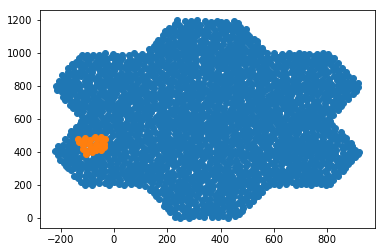

In [22]:
plt.scatter(xz_array[:, 1], xz_array[:, 2]) # background hexagonal structure
plt.scatter(times_xz[0][:, 1], times_xz[0][:, 2]) # single spike time pattern
plt.show()

### Batches <a class="anchor" id="batches"></a>

In [23]:
# Bin spike times into 200 ms intervals.
def batch(times, ms):
    batches_num = []
    batch_num = 0
    i_start = 0
    
    for i, time in enumerate(times):
        num = int(time // ms)
        if num > batch_num: # if new batch
            batch_num = num
            batches_num.append(slice(i_start, i))
            i_start = i
        if i == len(times)-1: # if last iteration
            batches_num.append(slice(i_start, i+1))
        # else continue
    
    return batches_num

In [24]:
batches_200 = batch(times, 200)

In [25]:
# Skip first second of random spiking.
batches_200 = batches_200[5:]

In [26]:
# Slices of the first 5 batches
print(*batches_200[:5], sep='\n')

slice(48, 74, None)
slice(74, 99, None)
slice(99, 121, None)
slice(121, 141, None)
slice(141, 169, None)


In [27]:
# Spike times for the first 2 batches
print(*[times[batch] for batch in batches_200[:2]], sep='\n')

[1003.01709  1006.668091 1008.762634 1009.857117 1010.063477 1012.734009
 1012.892151 1013.871765 1016.9823   1017.035095 1019.444946 1024.851929
 1030.419067 1031.902832 1032.075806 1032.199951 1032.354736 1036.21521
 1039.891479 1045.623535 1055.486084 1057.248901 1059.099487 1093.218872
 1164.550659 1181.100586]
[1200.406006 1201.653198 1209.508667 1210.584595 1217.297241 1220.279907
 1221.943481 1222.941528 1233.014404 1233.397827 1238.227417 1241.246338
 1246.926392 1256.834839 1258.001343 1259.338257 1261.332886 1261.621704
 1265.179688 1268.525879 1269.322998 1317.160034 1323.496216 1327.297729
 1342.979858]


In [28]:
# Number of spike times (blobs) for each presentation time
print(*[len(times[batch]) for batch in batches_200[:5]], sep='\n')

26
25
22
20
28


In [29]:
all([len(times[batch]) > 10 for batch in batches_200])

True

<span style="color:red">**NB** More than 10 spike times included in any presented frame!</span>

Choose unique blobs from batch (for error data).

In [30]:
batch_blobs = times_ids[batches_200[0]]

In [122]:
unique_blobs = [list(x) for x in set(tuple(x) for x in batch_blobs)]

In [124]:
choice = list(np.random.choice(unique_blobs, 2))

In [130]:
chosen = [x for x in batch_blobs if x in choice]

In [132]:
np.concatenate(chosen)

array([220702., 220709., 220717., 220719., 220731., 220896., 220911.,
       220920., 220955., 220960., 220963., 220965., 220973., 221007.,
       221013., 221015., 221016., 221037., 221352., 221353., 221354.,
       221355., 221356., 221357., 221358., 221359., 221360., 221361.,
       221362., 221364., 221365., 221366., 221367., 221368., 221369.,
       221370., 221374., 221377., 221378., 221380., 221382., 221399.,
       221400.])

In [20]:
with open('data/input/batches_200.pkl', 'wb') as f:
    pkl.dump(batches_200, f)

In [21]:
# `batches_200` - slices of indices for `times_xz` (200 ms batch times).
print(len(batches_200))
for i, batch in enumerate(batches_200):
    if i > 9:
        break
    else:
        print(batch)

145
slice(48, 74, None)
slice(74, 99, None)
slice(99, 121, None)
slice(121, 141, None)
slice(141, 169, None)
slice(169, 189, None)
slice(189, 217, None)
slice(217, 240, None)
slice(240, 263, None)
slice(263, 287, None)


In [21]:
# Make an animation representing all relevant 200 ms batches.
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(xz_array[:, 1], xz_array[:, 2])
ln, = ax.plot([], [], 'ro', alpha=0.5, animated=True)

ax.set(adjustable='box-forced', aspect='equal')

def update(frame):
    xz = np.vstack(times_xz[batches_200[frame]])
    ln.set_data(xz[:, 1], xz[:, 2])
    return ln,

ani = animation.FuncAnimation(fig, update, frames=len(batches_200),\
                              interval=500, blit=True)
ani.save("data/incite/batches_200.mp4", dpi=300)

In [62]:
# Make an animation representing first batch.
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(xz_array[:, 1], xz_array[:, 2])
ln, = ax.plot([], [], 'ro', alpha=0.5, animated=True)

ax.set(adjustable='box-forced', aspect='equal')

def update(frame):
    xz = times_xz[batches_200[0]][frame]
    ln.set_data(xz[:, 1], xz[:, 2])
    ax.set_title("time = {}".format(times[batches_200[0]][frame]))
    return ln,

ani = animation.FuncAnimation(fig, update, frames=len(times_xz[batches_200[0]]),\
                              interval=500, blit=True)
ani.save("data/incite/batches_200_0.mp4", dpi=300)

### `stim_train` <a class="anchor" id="stim-train"></a>

In [22]:
stim_train = [249980, 397555, 446691, 205315, 397555, 249980, \
              757795, 397555, 740558, 249980, 397555, 249980, \
              766947, 740558, 446691, 766947, 205315, 205315, \
              766947, 515018, 740558, 740558, 249980, 515018, \
              757795, 740558, 515018, 397555, 740558, 249980, \
              446691, 397555, 757795, 766947, 757795, 397555, \
              766947, 740558, 446691, 766947, 205315, 740558, \
              757795, 515018, 397555, 397555, 249980, 515018, \
              205315, 446691, 205315, 205315, 446691, 740558, \
              446691, 205315, 249980, 515018, 766947, 446691, \
              757795, 397555, 757795, 397555, 757795, 515018, \
              740558, 757795, 446691, 397555, 249980, 446691, \
              515018, 515018, 446691, 515018, 766947, 249980, \
              515018, 757795, 766947, 205315, 740558, 515018, \
              205315, 740558, 205315, 766947, 740558, 249980, \
              205315, 205315, 515018, 740558, 515018, 446691, \
              397555, 757795, 766947, 515018, 397555, 205315, \
              397555, 397555, 205315, 249980, 740558, 397555, \
              757795, 249980, 757795, 766947, 446691, 757795, \
              766947, 766947, 446691, 446691, 757795, 515018, \
              446691, 446691, 766947, 740558, 740558, 766947, \
              515018, 249980, 757795, 446691, 249980, 766947, \
              205315, 446691, 249980, 766947, 757795, 249980, \
              249980, 397555, 515018, 757795, 249980, 397555, 205315]

In [23]:
stim_train = np.array(stim_train)

In [24]:
with open('data/input/stim_train.pkl', 'wb') as f:
    pkl.dump(stim_train, f)

In [25]:
np.unique(stim_train)

array([205315, 249980, 397555, 446691, 515018, 740558, 757795, 766947])

In [26]:
len(stim_train)

145

#### Batches vs `stim_train`  <a class="anchor" id="batches-vs-stim"></a>
Check whether the 200 ms batches correctly represent `stim_train`.

In [27]:
# Contains GIDs for each 200 ms batch.
times_batched = [np.sort(np.vstack(times_xz[batch])[:, 0]) for batch in batches_200]

In [28]:
len(times_batched)

145

In [29]:
# Hash to check unique batches.
times_batched_hashed = [hash(batch.tostring()) for batch in times_batched]

In [30]:
np.unique(times_batched_hashed).shape

(145,)

This means that every batch has a unique set of fibres, which is how it should be.

**NB** This ↓ is equivalent to [**pattern sums**](#pattern-sums).

[  3  16  17  40  48  50  51  55  81  84  86  90  91 101 104 132 144]


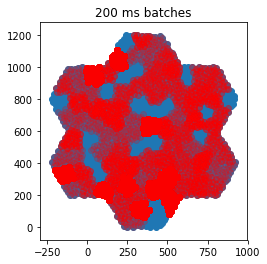

In [31]:
# Pick all indices from `stim_train` with the same specific value (representing the same pattern).
# 200 ms batches
pick = np.argwhere(stim_train == 205315).reshape(-1)
print(pick)

fig, ax = plt.subplots(figsize=(4, 4))

ax.set_title('200 ms batches')
ax.set(adjustable='box-forced', aspect='equal')
ax.scatter(xz_array[:, 1], xz_array[:, 2]) # background hexagonal structure
for i in pick:
    xz = np.vstack(times_xz[batches_200[i]])
    ax.scatter(xz[:, 1], xz[:, 2], c='r', alpha=0.2)
plt.show()

Plot all the input frames representing the same pattern (`pick` from previous cell).

In [33]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(xz_array[:, 1], xz_array[:, 2])
ln, = ax.plot([], [], 'ro', alpha=0.5, animated=True)

ax.set(adjustable='box-forced', aspect='equal')

def update(frame):
    xz = np.vstack(times_xz[batches_200[pick[frame]]])
    ln.set_data(xz[:, 1], xz[:, 2])
    return ln,

ani = animation.FuncAnimation(fig, update, frames=len(pick),\
                              interval=500, blit=True)
ani.save("data/incite/205315.mp4", dpi=300)

### GID to `xz_array` Index & Creating `x_data` <a class="anchor" id="creating-x-data"></a>

In [64]:
# GID --> index in `xz_array`.
GID_to_num = {val: ind for ind, val in enumerate(xz_array[:, 0])}

In [65]:
with open('data/input/GID_to_num.pkl', 'wb') as f:
    pkl.dump(GID_to_num, f)

In [110]:
np.random.choice(times_xz[batches_200[0]], 2)

array([array([[221352.   ,    680.94 ,    394.053],
       [221353.   ,    686.353,    411.63 ],
       [221354.   ,    702.589,    389.366],
       [221355.   ,    707.776,    407.821],
       [221356.   ,    675.979,    376.77 ],
       [221357.   ,    723.674,    398.569],
       [221358.   ,    701.687,    430.768],
       [221359.   ,    675.416,    429.328],
       [221360.   ,    719.622,    378.761],
       [221361.   ,    659.179,    411.752],
       [221362.   ,    696.275,    363.978],
       [221364.   ,    677.332,    359.682],
       [221365.   ,    731.454,    420.613],
       [221366.   ,    689.179,    444.184],
       [221367.   ,    718.826,    438.19 ],
       [221368.   ,    741.377,    396.397],
       [221369.   ,    713.414,    354.995],
       [221370.   ,    736.641,    376.575],
       [221374.   ,    707.438,    452.08 ],
       [221377.   ,    692.216,    342.789],
       [221378.   ,    750.397,    410.849],
       [221380.   ,    742.279,    436.237],
   

In [228]:
def create_data_old(times_xz=times_xz, batches_200=batches_200, GID_to_num=GID_to_num, missing_blobs=0):
    x_data = []
    for batch in batches_200:
        batch_gids = np.vstack(times_xz[batch][missing_blobs:])[:, 0]
        batch_gid_nums = [GID_to_num[key] for key in batch_gids]
        data = np.bincount(batch_gid_nums)
        data = np.concatenate((data, np.zeros(len(GID_to_num.keys()) - len(data))))
        x_data.append(data)
    x_data = np.array(x_data)
    x_data = x_data / np.max(x_data)
    return x_data

In [229]:
def create_data(times_xz=times_xz, batches_200=batches_200, GID_to_num=GID_to_num, missing_blobs=0):
    x_data = []
    for batch in batches_200:
        if missing_blobs != 0:
            batch_gids = np.vstack(np.random.choice(times_xz[batch], \
                                                    len(times_xz[batch]) - missing_blobs, False))[:, 0]
        else:
            batch_gids = np.vstack(times_xz[batch])[:, 0]
        batch_gid_nums = [GID_to_num[key] for key in batch_gids]
        data = np.bincount(batch_gid_nums)
        data = np.concatenate((data, np.zeros(len(GID_to_num.keys()) - len(data))))
        x_data.append(data)
    x_data = np.array(x_data)
    x_data = x_data / np.max(x_data)
    return x_data

In [118]:
x_data = create_data()

In [119]:
x_data.shape

(145, 2170)

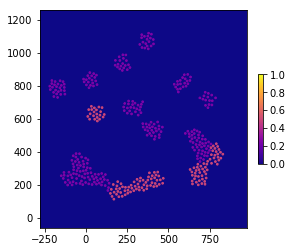

In [114]:
plot([x_data[0]], show=True, save=False)

In [38]:
# `x_data` - input to autoencoder.
# Normalized spike counts for each 200 ms bin.
print(x_data.shape)
print(x_data[:10, :10])
print(np.max(x_data))

(145, 2170)
[[ 0.    0.    0.    0.25  0.    0.    0.    0.25  0.    0.  ]
 [ 0.25  0.    0.    0.    0.    0.    0.    0.    0.    0.25]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.5   0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.5   0.25  0.    0.    0.    0.    0.    0.    0.    0.5 ]
 [ 0.    0.    0.    0.5   0.    0.    0.    0.75  0.    0.  ]
 [ 0.25  0.    0.    0.    0.    0.    0.    0.    0.    0.25]
 [ 0.5   0.    0.    0.    0.    0.    0.    0.    0.    0.5 ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.25  0.25  0.    0.    0.5   0.    0.  ]]
1.0


In [154]:
# Divide into train and test sets.
def get_train_test(x_data, train_ratio=0.8):
    div_ind = int(len(x_data)*train_ratio)
    x_train = x_data[:div_ind]
    x_test = x_data[div_ind:]
    return x_train, x_test

In [40]:
x_train, x_test = get_train_test(x_data)

In [41]:
x_train.shape, x_test.shape

((116, 2170), (29, 2170))

In [42]:
with open('data/input/x_train.pkl', 'wb') as f:
    pkl.dump(x_train, f)
with open('data/input/x_test.pkl', 'wb') as f:
    pkl.dump(x_test, f)

## Error Correction Dataset <a class="anchor" id="error-correction-dataset"></a>

In [106]:
with open('data/input/times_xz.pkl', 'rb') as f:
    times_xz = pkl.load(f)
with open('data/input/batches_200.pkl', 'rb') as f:
    batches_200 = pkl.load(f)
with open('data/input/GID_to_num.pkl', 'rb') as f:
    GID_to_num = pkl.load(f)

`create_data()` function in the previous section accounts for the number of time instances/blobs to delete.

In [128]:
x_data_2blobs = create_data(times_xz, batches_200, GID_to_num, missing_blobs=2)

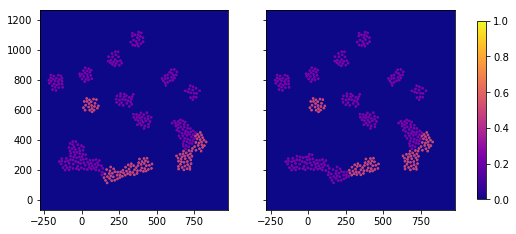

In [129]:
plot([x_data[0], x_data_2blobs[0]], show=True, save=False)

# Autoencoder <a class="anchor" id="autoencoder"></a>
## Building <a class="anchor" id="building"></a>

In [129]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers

In [386]:
def build_autoenc(encoding_dim=8, input_shape=(2170,), optimizer='adadelta', loss='binary_crossentropy', sparsity=0):

    # this is the size of our encoded representations
    encoding_dim = encoding_dim

    # this is our input placeholder
    input_img = Input(shape=input_shape)
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu', \
                    activity_regularizer=regularizers.l1(sparsity))(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(input_shape[0], activation='sigmoid')(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)

    # this model maps an input to its encoded representation
    encoder = Model(input_img, encoded)

    # create a placeholder for an encoded (encoding_dim-dimensional) input
    encoded_input = Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    decoder = Model(encoded_input, decoder_layer(encoded_input))

    autoencoder.compile(optimizer=optimizer, loss=loss)  

    return autoencoder, encoder, decoder

## Training <a class="anchor" id="training"></a>

In [131]:
with open('data/input/x_train.pkl', 'rb') as f:
    x_train = pkl.load(f)
with open('data/input/x_test.pkl', 'rb') as f:
    x_test = pkl.load(f)

In [132]:
# `AppendedHistory` - a class I wrote for one of the miniprojects for ANNs course
#                     and modified for this project.
#                     It allows storing and plotting parametrised learning curves.
from helpers.AppendedHistory import AppendedHistory
# Reloads modules automatically when they are changed.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
from keras.callbacks import EarlyStopping

### Simple Autoencoder <a class="anchor" id="simple-autoencoder"></a>

In [371]:
history_sl = AppendedHistory(varname='Rounds', keys=['loss'])

In [372]:
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, restore_best_weights=True)
for i in range(5):
    print('Round {}'.format(i))
    autoencoder, encoder, decoder = build_autoenc(optimizer='adam')
    history = autoencoder.fit(x_train, x_train, \
                              epochs=1000, \
                              batch_size=1, \
                              shuffle=True, \
                              validation_data=(x_test, x_test), \
                              verbose=0, callbacks=[callback])
    history_sl.append_hist(i, history)
    autoencoder.save('data/incite/models_log/ae/simple/autoencoder_{}'.format(i))
    encoder.save('data/incite/models_log/ae/simple/encoder_{}'.format(i))
    decoder.save('data/incite/models_log/ae/simple/decoder_{}'.format(i))

Round 0
Round 1
Round 2
Round 3
Round 4


In [373]:
history_sl.save('data/incite/models_log/ae/simple/history_sl')

In [52]:
history_sl = AppendedHistory(fname='data/incite/models_log/ae/simple/history_sl')

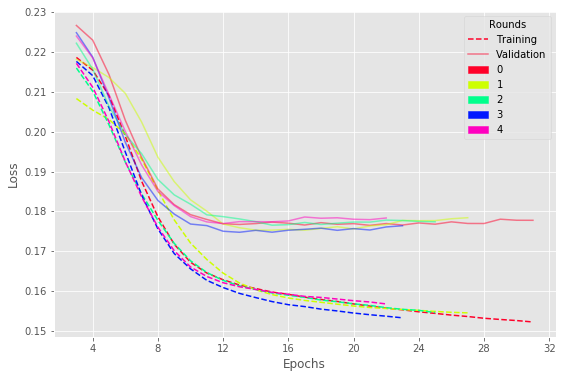

In [53]:
history_sl.plot("", "loss", False, [3, 100], True)

In [54]:
load_model('data/incite/models_log/ae/simple/autoencoder_3').evaluate(x_test, x_test, batch_size=1)

29/29 [==============================] - 0s 1ms/step


0.17473595666474309

#### Sparse Simple Autoencoder <a class="anchor" id="sparse-autoencoder"></a>

In [350]:
history_sp = AppendedHistory(varname='Sparsity', keys=['loss'])

In [351]:
sparsities = [1e-07, 1e-06, 1e-05, 1e-04, 1e-03, 1e-02]
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, restore_best_weights=True)
for sparsity in sparsities:
    print('sparsity = {}'.format(sparsity))
    autoencoder, encoder, decoder = build_autoenc(sparsity=sparsity)
    history = autoencoder.fit(x_train, x_train, \
                              epochs=1000, \
                              batch_size=1, \
                              shuffle=True, \
                              validation_data=(x_test, x_test), \
                              verbose=0, callbacks=[callback])
    history_sp.append_hist(sparsity, history)
    autoencoder.save('data/incite/models_log/ae/simple/sparse/autoencoder_sp_{}'.format(sparsity))
    encoder.save('data/incite/models_log/ae/simple/sparse/encoder_sp_{}'.format(sparsity))
    decoder.save('data/incite/models_log/ae/simple/sparse/decoder_sp_{}'.format(sparsity))

sparsity = 1e-07
sparsity = 1e-06
sparsity = 1e-05
sparsity = 0.0001
sparsity = 0.001
sparsity = 0.01


In [352]:
history_sp.save('data/incite/models_log/ae/simple/sparse/history_sp')

In [55]:
history_sp = AppendedHistory(fname='data/incite/models_log/ae/simple/sparse/history_sp')

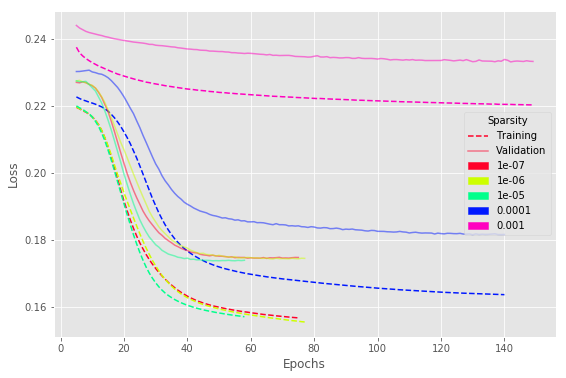

In [56]:
history_sp.get_slice(slice(0, -1, 1)).plot("", "loss", False, [5, 150], True)

In [57]:
load_model('data/incite/models_log/ae/simple/sparse/autoencoder_sp_1e-05').evaluate(x_test, x_test, batch_size=1)

29/29 [==============================] - 0s 2ms/step


0.17371048136004086

`sparsity=10e-05` yielded best loss, so let's train a few AEs with this parameter to pick the best performing.

In [359]:
history_best = AppendedHistory(varname='Rounds', keys=['loss'])

In [361]:
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, restore_best_weights=True)
for i in range(5):
    print('Round {}'.format(i))
    autoencoder, encoder, decoder = build_autoenc(sparsity=1e-05)
    history = autoencoder.fit(x_train, x_train, \
                              epochs=1000, \
                              batch_size=1, \
                              shuffle=True, \
                              validation_data=(x_test, x_test), \
                              verbose=0, callbacks=[callback])
    history_best.append_hist(i, history)
    autoencoder.save('data/incite/models_log/ae/simple/sparse/best/autoencoder_sp_1e-05_{}'.format(i))
    encoder.save('data/incite/models_log/ae/simple/sparse/best/encoder_sp_1e-05_{}'.format(i))
    decoder.save('data/incite/models_log/ae/simple/sparse/best/decoder_sp_1e-05_{}'.format(i))

Round 0
Round 1
Round 2
Round 3
Round 4


In [362]:
history_best.save('data/incite/models_log/ae/simple/sparse/best/history_best')

In [58]:
history_best = AppendedHistory(fname='data/incite/models_log/ae/simple/sparse/best/history_best')

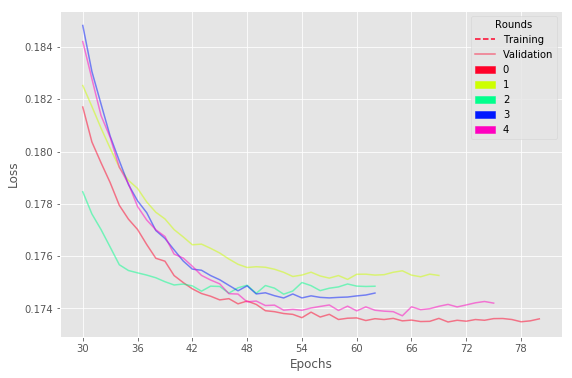

In [59]:
history_best.plot("", "val_loss", False, [30, 200], False)

In [60]:
load_model('data/incite/models_log/ae/simple/sparse/best/autoencoder_sp_1e-05_0').evaluate(x_test, x_test, batch_size=1)

29/29 [==============================] - 0s 2ms/step


0.1734848202302538

Model on **round 0** is the best. Let's consider it the best **sparse simple AE model**.

In [66]:
fnames = ['data/incite/models_log/ae/simple/autoencoder_3', \
          'data/incite/models_log/ae/simple/sparse/best/autoencoder_sp_1e-05_1']
folder = 'data/incite/models_log/ae/simple/sl_vs_sp_comp_hist/'
get_comp_hist(fnames, folder=folder, labels=['dense', 'sparse'])

#### `batch_size` and Loss <a class="anchor" id="batch-size-and-loss"></a>

##### Sparse `adadelda` <a class="anchor" id="sp-adadelta"></a>

In [235]:
history_sp_bs = AppendedHistory(varname='Rounds', keys=['loss'])

In [236]:
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, restore_best_weights=True)
batch_sizes = [1, 16, 32]
for batch_size in batch_sizes:
    print('batch_size = {}'.format(batch_size))
    autoencoder, encoder, decoder = build_autoenc(sparsity=1e-05)
    history = autoencoder.fit(x_train, x_train, \
                              epochs=1000, \
                              batch_size=batch_size, \
                              shuffle=True, \
                              validation_data=(x_test, x_test), \
                              verbose=0, callbacks=[callback])
    history_sp_bs.append_hist(batch_size, history)
    autoencoder.save('data/incite/models_log/ae/simple/batch_size/autoencoder_sp_1e-05_bs_{}'.format(batch_size))
    encoder.save('data/incite/models_log/ae/simple/batch_size/encoder_sp_1e-05_bs_{}'.format(batch_size))
    decoder.save('data/incite/models_log/ae/simple/batch_size/decoder_sp_1e-05_bs_{}'.format(batch_size))

batch_size = 1
batch_size = 16
batch_size = 32


In [264]:
history_sp_bs.save('data/incite/models_log/ae/simple/batch_size/history_sp_bs')

In [75]:
history_sp_bs = AppendedHistory(fname='data/incite/models_log/ae/simple/batch_size/history_sp_bs')

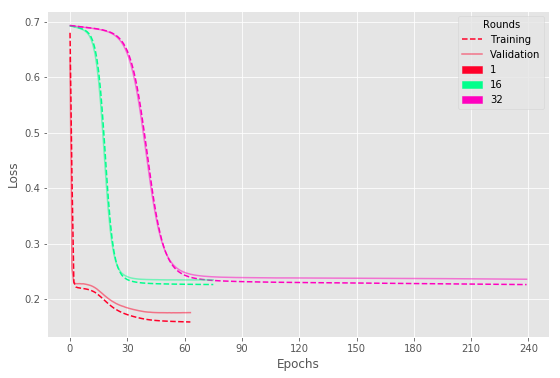

In [76]:
history_sp_bs.plot("", "loss", False, [0, 240], True)

##### Sparse `adam` <a class="anchor" id="sp-adam"></a>

In [323]:
history_sp_bs_adam = AppendedHistory(varname='batch_size', keys=['loss'])

In [324]:
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, restore_best_weights=True)
batch_sizes = [1, 16, 32]
for batch_size in batch_sizes:
    print('batch_size = {}'.format(batch_size))
    autoencoder, encoder, decoder = build_autoenc(sparsity=1e-05, optimizer='adam')
    history = autoencoder.fit(x_train, x_train, \
                              epochs=1000, \
                              batch_size=batch_size, \
                              shuffle=True, \
                              validation_data=(x_test, x_test), \
                              verbose=0, callbacks=[callback])
    history_sp_bs_adam.append_hist(batch_size, history)
    autoencoder.save('data/incite/models_log/ae/simple/batch_size/autoencoder_sp_1e-05_bs_{}_adam'.format(batch_size))
    encoder.save('data/incite/models_log/ae/simple/batch_size/encoder_sp_1e-05_bs_{}_adam'.format(batch_size))
    decoder.save('data/incite/models_log/ae/simple/batch_size/decoder_sp_1e-05_bs_{}_adam'.format(batch_size))

batch_size = 1
batch_size = 16
batch_size = 32


In [325]:
history_sp_bs_adam.save('data/incite/models_log/ae/simple/batch_size/history_sp_1e-05_bs_adam')

In [78]:
history_sp_bs_adam = AppendedHistory(fname='data/incite/models_log/ae/simple/batch_size/history_sp_1e-05_bs_adam')

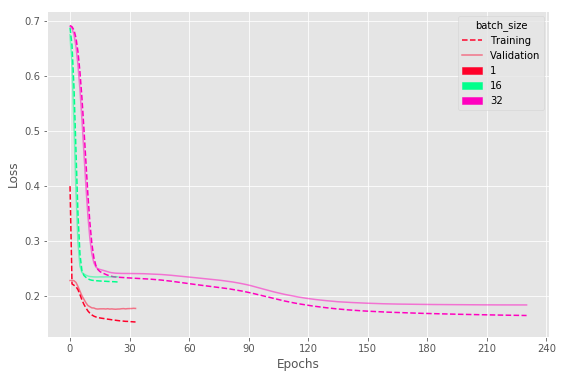

In [79]:
history_sp_bs_adam.plot("", "loss", False, [0, 240], True)

##### Simple `adadelta` <a class="anchor" id="sl-adadelta"></a>

In [337]:
history_bs = AppendedHistory(varname='batch_size', keys=['loss'])

In [338]:
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, restore_best_weights=True)
batch_sizes = [1, 16, 32]
for batch_size in batch_sizes:
    print('batch_size = {}'.format(batch_size))
    autoencoder, encoder, decoder = build_autoenc()
    history = autoencoder.fit(x_train, x_train, \
                              epochs=1000, \
                              batch_size=batch_size, \
                              shuffle=True, \
                              validation_data=(x_test, x_test), \
                              verbose=0, callbacks=[callback])
    history_bs.append_hist(batch_size, history)
    autoencoder.save('data/incite/models_log/ae/simple/batch_size/autoencoder_bs_{}'.format(batch_size))
    encoder.save('data/incite/models_log/ae/simple/batch_size/encoder_bs_{}'.format(batch_size))
    decoder.save('data/incite/models_log/ae/simple/batch_size/decoder_bs_{}'.format(batch_size))

batch_size = 1
batch_size = 16
batch_size = 32


In [339]:
history_bs.save('data/incite/models_log/ae/simple/batch_size/history_bs')

In [340]:
history_bs = AppendedHistory(fname='data/incite/models_log/ae/simple/batch_size/history_bs')

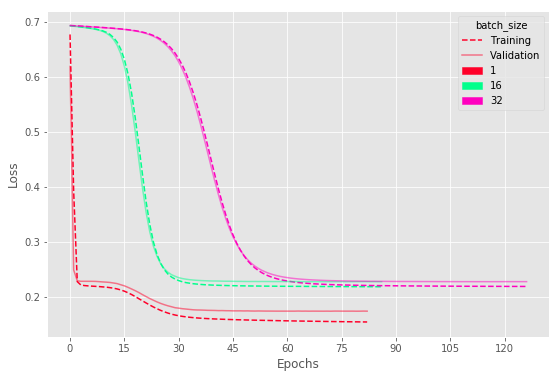

In [341]:
history_bs.plot("", "loss", False, None, True)

### Low-dimentional Autoencoder <a class="anchor" id="lim-dim-ae"></a>

In [44]:
history_ldim = AppendedHistory(varname='Encoding Dimension', keys=['loss'])

In [45]:
for i in [2, 4, 6]:
    autoencoder, encoder, decoder = build_autoenc(encoding_dim=i)
    history = autoencoder.fit(x_train, x_train, \
                              epochs=100, \
                              batch_size=1, \
                              shuffle=True, \
                              validation_data=(x_test, x_test), \
                              verbose=0)
    autoencoder.save('data/incite/models_log/ae/simple/ldim/autoencoder_ldim_{}_100eps'.format(i))
    encoder.save('data/incite/models_log/ae/simple/ldim/encoder_ldim_{}_100eps'.format(i))
    decoder.save('data/incite/models_log/ae/simple/ldim/decoder_ldim_{}_100eps'.format(i))
    history_ldim.append_hist(i, history)
    
    history = autoencoder.fit(x_train, x_train, \
                              epochs=100, \
                              batch_size=1, \
                              shuffle=True, \
                              validation_data=(x_test, x_test), \
                              verbose=0)
    autoencoder.save('data/incite/models_log/ae/simple/ldim/autoencoder_ldim_{}_200eps'.format(i))
    encoder.save('data/incite/models_log/ae/simple/ldim/encoder_ldim_{}_200eps'.format(i))
    decoder.save('data/incite/models_log/ae/simple/ldim/decoder_ldim_{}_200eps'.format(i))
    history_ldim.add_hist(i, history)

In [48]:
history_ldim.save('data/incite/models_log/encdims/history_ldim')

In [49]:
history_ldim = AppendedHistory(fname='data/incite/models_log/encdims/history_ldim')

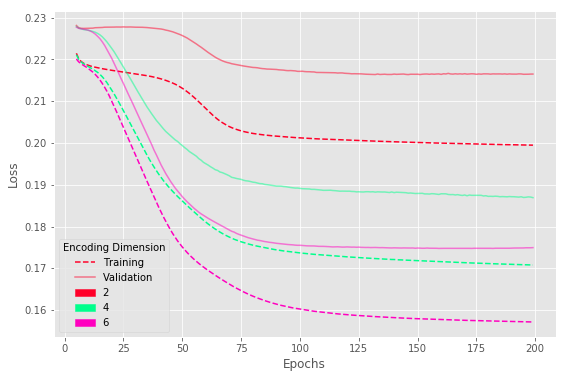

In [52]:
history_ldim.plot("", "loss", False, [5, 200], True)

### Deep Autoencoder <a class="anchor" id="deep-autoencoder"></a>

In [387]:
def build_deep_autoenc(encoding_dim=8, input_shape=(2170,), num_hid=1, loss='binary_crossentropy', sparsity=0):
    input_img = Input(shape=input_shape)
    
    prev_layer = input_img
    for hidden_dim in np.linspace(encoding_dim, input_shape, num_hid+2).astype(int)[::-1][1:]:
        layer = Dense(hidden_dim, activation='relu', \
                      activity_regularizer=regularizers.l1(sparsity))(prev_layer)
        prev_layer = layer

    # this model maps an input to its encoded representation
    deep_encoder = Model(input_img, prev_layer)

    for hidden_dim in np.linspace(encoding_dim, input_shape, num_hid+2).astype(int)[1:-1]:
        layer = Dense(hidden_dim, activation='relu', \
                      activity_regularizer=regularizers.l1(sparsity))(prev_layer)
        prev_layer = layer
        
    decoded = Dense(input_shape[0], activation='sigmoid', \
                      activity_regularizer=regularizers.l1(sparsity))(prev_layer)

    deep_autoencoder = Model(input_img, decoded)
    deep_autoencoder.compile(optimizer='adadelta', loss=loss)
    
#    encoded_input = Input(shape=(encoding_dim,))
#    decoder_layer = deep_autoencoder.layers[-1]
#    deep_decoder = Model(encoded_input, decoder_layer(encoded_input))
    
    return deep_autoencoder, deep_encoder #, deep_decoder

In [388]:
deep_autoencoder, deep_encoder = build_deep_autoenc()

In [389]:
deep_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        (None, 2170)              0         
_________________________________________________________________
dense_250 (Dense)            (None, 1089)              2364219   
_________________________________________________________________
dense_251 (Dense)            (None, 8)                 8720      
_________________________________________________________________
dense_252 (Dense)            (None, 1089)              9801      
_________________________________________________________________
dense_253 (Dense)            (None, 2170)              2365300   
Total params: 4,748,040
Trainable params: 4,748,040
Non-trainable params: 0
_________________________________________________________________


In [390]:
history_deep = AppendedHistory(varname='num_hid', keys=['loss'])

In [391]:
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, restore_best_weights=True)
for i in range(5):
    print('num_hid = {}'.format(i))
    deep_autoencoder, deep_encoder = build_deep_autoenc(num_hid=i)
    %time history = deep_autoencoder.fit(x_train, x_train, \
                              epochs=500, \
                              batch_size=32, \
                              shuffle=True, \
                              validation_data=(x_test, x_test), \
                              verbose=0, callbacks=[callback])
    history_deep.append_hist(i, history)
    deep_autoencoder.save('data/incite/models_log/ae/deep/deep_autoencoder_num-hid_{}'.format(i))
    deep_encoder.save('data/incite/models_log/ae/deep/deep_encoder_num-hid_{}'.format(i))

num_hid = 0
CPU times: user 16.5 s, sys: 842 ms, total: 17.3 s
Wall time: 14.7 s
num_hid = 1
CPU times: user 51.5 s, sys: 12.8 s, total: 1min 4s
Wall time: 31.9 s
num_hid = 2
CPU times: user 1min 49s, sys: 35.2 s, total: 2min 24s
Wall time: 58.3 s
num_hid = 3
CPU times: user 1min 38s, sys: 31.9 s, total: 2min 10s
Wall time: 52.7 s
num_hid = 4
CPU times: user 2min 49s, sys: 1min 4s, total: 3min 53s
Wall time: 1min 28s


In [392]:
history_deep.save('data/incite/models_log/ae/deep/history_deep')

In [393]:
history_deep = AppendedHistory(fname='data/incite/models_log/ae/deep/history_deep')

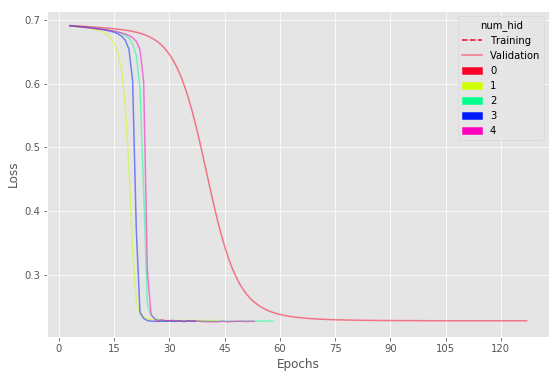

In [396]:
history_deep.plot("", "val_loss", False, [3, 500], False)

In [407]:
load_model('data/incite/models_log/ae/deep/deep_autoencoder_num-hid_3').evaluate(x_test, x_test, batch_size=32)

29/29 [==============================] - 2s 86ms/step


0.2265489250421524

In [399]:
history_deep_sp = AppendedHistory(varname='num_hid', keys=['loss'])

In [400]:
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, restore_best_weights=True)
for i in range(5):
    print('num_hid = {}'.format(i))
    deep_autoencoder, deep_encoder = build_deep_autoenc(sparsity=1e-05, num_hid=i)
    %time history = deep_autoencoder.fit(x_train, x_train, \
                              epochs=500, \
                              batch_size=32, \
                              shuffle=True, \
                              validation_data=(x_test, x_test), \
                              verbose=0, callbacks=[callback])
    history_deep_sp.append_hist(i, history)
    deep_autoencoder.save('data/incite/models_log/ae/deep/sparse/deep_autoencoder_sp_1e-05_num-hid_{}'.format(i))
    deep_encoder.save('data/incite/models_log/ae/deep/sparse/deep_encoder_sp_1e-05_num-hid_{}'.format(i))

num_hid = 0
CPU times: user 18.4 s, sys: 842 ms, total: 19.2 s
Wall time: 15.7 s
num_hid = 1
CPU times: user 8min 31s, sys: 2min 29s, total: 11min 1s
Wall time: 4min 1s
num_hid = 2
CPU times: user 14min 8s, sys: 5min 2s, total: 19min 11s
Wall time: 7min 34s
num_hid = 3
CPU times: user 20min 10s, sys: 7min 39s, total: 27min 49s
Wall time: 10min 42s
num_hid = 4
CPU times: user 28min 31s, sys: 11min 11s, total: 39min 43s
Wall time: 13min 19s


In [401]:
history_deep_sp.save('data/incite/models_log/ae/deep/sparse/history_deep_sp_1e-05')

In [402]:
history_deep_sp = AppendedHistory(fname='data/incite/models_log/ae/deep/sparse/history_deep_sp_1e-05')

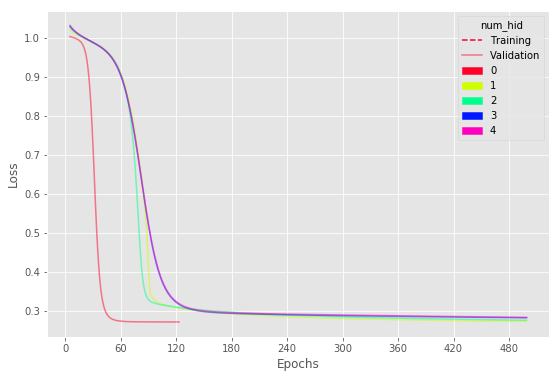

In [405]:
history_deep_sp.plot("", "val_loss", False, [5, 500], False)

### Denoising Autoencoder <a class="anchor" id="denoising-autoencoder"></a>

In [134]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [279]:
x_train_blobs = get_train_test(create_data(missing_blobs=15))[0]
x_test_blobs = get_train_test(create_data(missing_blobs=15))[1]

In [281]:
history_dn = AppendedHistory(varname='num_hid', keys=['loss'])

In [282]:
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, restore_best_weights=True)
for i in range(4, 5):
    print('num_hid = {}'.format(i))
    dn_autoencoder, dn_encoder = build_deep_autoenc(num_hid=i, loss='mean_squared_error')
    %time history = dn_autoencoder.fit(x_train_blobs, x_train, \
                              epochs=300, \
                              batch_size=32, \
                              shuffle=True, \
                              validation_data=(x_test_blobs, x_test), \
                              verbose=0, callbacks=[callback])
    history_dn.append_hist(i, history)
    dn_autoencoder.save('data/incite/models_log/ae/denoising/dn_autoencoder_num-hid_{}'.format(i))
    dn_encoder.save('data/incite/models_log/ae/denoising/dn_encoder_num-hid_{}'.format(i))

num_hid = 4
CPU times: user 14min 11s, sys: 5min 29s, total: 19min 40s
Wall time: 7min 3s


In [283]:
history_dn.save('data/incite/models_log/ae/denoising/history_dn')

In [284]:
history_dn = AppendedHistory(fname='data/incite/models_log/ae/denoising/history_dn')

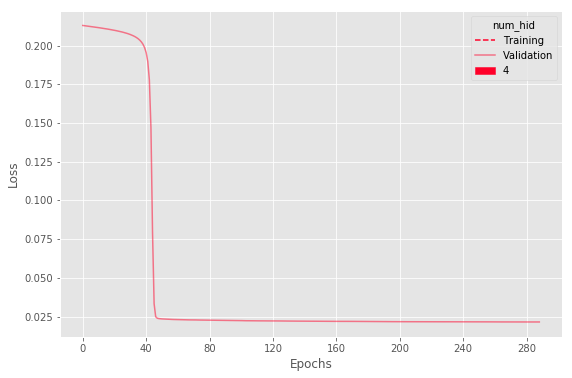

In [285]:
history_dn.plot("", "val_loss", False, None, False)

In [213]:
load_model('data/incite/models_log/ae/denoising/dn_autoencoder_num-hid_4').evaluate(x_test_blobs, x_test)

29/29 [==============================] - 1s 46ms/step


0.22229692339897156

In [214]:
load_model('data/incite/models_log/ae/denoising/dn_autoencoder_num-hid_4_bs_32').evaluate(x_test_blobs, x_test)

29/29 [==============================] - 1s 48ms/step


0.23087117075920105

# Readout <a class="anchor" id="readout"></a>
## Dataset for Representation Training <a class="anchor" id="repr_data"></a>
### Output <a class="anchor" id="repr_data_out"></a>

In [219]:
with open('data/input/stim_train.pkl', 'rb') as f:
    stim_train = pkl.load(f)

In [220]:
stim_train_2_one_hot = {}
one_hot = np.zeros(8)
for i, pattern in enumerate(np.unique(stim_train)):
    hot = np.copy(one_hot)
    hot[i] = 1
    stim_train_2_one_hot[pattern] = hot

In [221]:
stim_train_2_one_hot

{205315: array([1., 0., 0., 0., 0., 0., 0., 0.]),
 249980: array([0., 1., 0., 0., 0., 0., 0., 0.]),
 397555: array([0., 0., 1., 0., 0., 0., 0., 0.]),
 446691: array([0., 0., 0., 1., 0., 0., 0., 0.]),
 515018: array([0., 0., 0., 0., 1., 0., 0., 0.]),
 740558: array([0., 0., 0., 0., 0., 1., 0., 0.]),
 757795: array([0., 0., 0., 0., 0., 0., 1., 0.]),
 766947: array([0., 0., 0., 0., 0., 0., 0., 1.])}

In [372]:
cl_x_train_out = np.array([stim_train_2_one_hot[pattern] for pattern in stim_train[:116]])
cl_x_test_out = np.array([stim_train_2_one_hot[pattern] for pattern in stim_train[116:]])

In [ ]:
with open('data/input/cl_x_train_out.pkl', 'wb') as f:
    pkl.dump(cl_x_train_out, f)
with open('data/input/cl_x_test_out.pkl', 'wb') as f:
    pkl.dump(cl_x_test_out, f)

## Building <a class="anchor" id="ro_building"></a>

In [292]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.metrics import categorical_accuracy

In [293]:
def build_readout(output_dim=8, num_hid=0, hidden_dim=8, input_shape=(8,), sparsity=0, \
                  activation='sigmoid', optimizer='adam', \
                  loss='categorical_crossentropy', metrics=[categorical_accuracy]):

    output_dim = output_dim

    input_repr = Input(shape=input_shape)
    
    prev_layer = input_repr
    hidden_layers = [prev_layer]
    for i in range(num_hid):
        layer = Dense(hidden_dim, activation='relu', \
                      activity_regularizer=regularizers.l1(sparsity))(prev_layer)
        hidden_layers.append(layer)
        prev_layer = layer

    output_layer = Dense(output_dim, activation=activation)(hidden_layers[-1])

    readout = Model(input_repr, output_layer)

    readout.compile(optimizer=optimizer, loss=loss, metrics=metrics)  

    return readout

## Training <a class="anchor" id="ro_training"></a>

In [259]:
with open('data/input/x_train.pkl', 'rb') as f:
    x_train = pkl.load(f)
with open('data/input/x_test.pkl', 'rb') as f:
    x_test = pkl.load(f)
with open('data/input/cl_x_train_in.pkl', 'rb') as f:
    cl_x_train_in = pkl.load(f)
with open('data/input/cl_x_test_in.pkl', 'rb') as f:
    cl_x_test_in = pkl.load(f)
with open('data/input/cl_x_train_out.pkl', 'rb') as f:
    cl_x_train_out = pkl.load(f)
with open('data/input/cl_x_test_out.pkl', 'rb') as f:
    cl_x_test_out = pkl.load(f)

In [294]:
# `AppendedHistory` - a class I wrote for one of the miniprojects for ANNs course
#                     and modified for this project.
#                     It allows storing and plotting parametrised learning curves.
from helpers.AppendedHistory import AppendedHistory
# Reloads modules automatically when they are changed.
%load_ext autoreload
%autoreload 2

In [295]:
from keras.callbacks import EarlyStopping

### On Input <a class="anchor" id="on-input"></a>

#### No Hidden Layers

In [124]:
history_in_losses = AppendedHistory(varname='Loss')

In [125]:
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, restore_best_weights=True)
losses = ['mean_squared_error', 'binary_crossentropy', 'categorical_crossentropy']
for loss in losses:
    print('loss = {}'.format(loss))
    readout = build_readout(num_hid=0, input_shape=(2170,), loss=loss)
    %time history = readout.fit(x_train, cl_x_train_out, \
                          epochs=300, \
                          batch_size=1, \
                          shuffle=True, \
                          validation_data=(x_test, cl_x_test_out), \
                          verbose=0, callbacks=[callback])
    history.history['acc'] = history.history.pop('categorical_accuracy')
    history.history['val_acc'] = history.history.pop('val_categorical_accuracy')
    history_in_losses.append_hist(loss, history)
    readout.save('data/incite/models_log/readout/ro_in_loss_{}'.format(loss))

loss = mean_squared_error
loss = binary_crossentropy
loss = categorical_crossentropy


In [130]:
history_in_losses.save('data/incite/models_log/readout/history_in_losses')

In [131]:
history_in_losses = AppendedHistory(fname='data/incite/models_log/readout/history_in_losses')

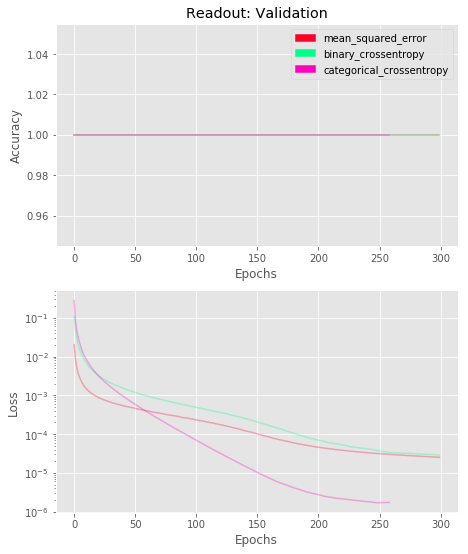

In [132]:
history_in_losses.plot_acc_loss("Readout: Validation", "val_")

In [146]:
history_in = AppendedHistory(varname='Round')

In [147]:
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, restore_best_weights=True)
for i in range(5):
    print('Round {}'.format(i))
    readout = build_readout(num_hid=0, input_shape=(2170,))
    history = readout.fit(x_train, cl_x_train_out, \
                          epochs=300, \
                          batch_size=1, \
                          shuffle=True, \
                          validation_data=(x_test, cl_x_test_out), \
                          verbose=0, callbacks=[callback])
    history.history['acc'] = history.history.pop('categorical_accuracy')
    history.history['val_acc'] = history.history.pop('val_categorical_accuracy')
    history_in.append_hist(i, history)
    readout.save('data/incite/models_log/readout/ro_in_{}'.format(i))

Round 0
Round 1
Round 2
Round 3
Round 4


In [148]:
history_in.save('data/incite/models_log/readout/history_in')

In [149]:
history_in = AppendedHistory(fname='data/incite/models_log/readout/history_in')

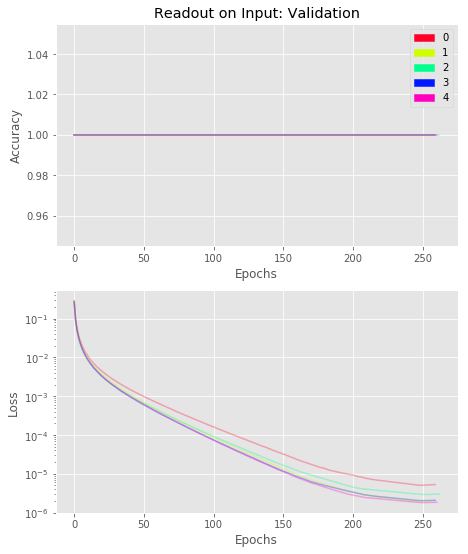

In [230]:
history_in.plot_acc_loss("Readout on Input: Validation", "val_")

#### Best Model <a class="anchor" id="on-input-best"></a>

In [152]:
load_model('data/incite/models_log/readout/ro_in_4').evaluate(x_test, cl_x_test_out, batch_size=1)

29/29 [==============================] - 0s 13ms/step


[1.7984334781548852e-06, 1.0]

### On Representations <a class="anchor" id="on-repr"></a>

Here I use the best sparse model of a simple AE.

In [234]:
history_repr_losses = AppendedHistory(varname='Loss')

In [220]:
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, restore_best_weights=True)
losses = ['mean_squared_error', 'binary_crossentropy', 'categorical_crossentropy']
for loss in losses:
    print('loss = {}'.format(loss))
    readout = build_readout(loss=loss)
    history = readout.fit(cl_x_train_in, cl_x_train_out, \
                            epochs=500, \
                            batch_size=1, \
                            shuffle=True, \
                            validation_data=(cl_x_test_in, cl_x_test_out), \
                            verbose=0, callbacks=[callback])
    history.history['acc'] = history.history.pop('categorical_accuracy')
    history.history['val_acc'] = history.history.pop('val_categorical_accuracy')
    history_repr_losses.append_hist(loss, history)
    readout.save('data/incite/models_log/readout/ro_repr_loss_{}'.format(loss))

loss = mean_squared_error
loss = binary_crossentropy
loss = categorical_crossentropy


In [221]:
history_repr_losses.save('data/incite/models_log/readout/history_repr_losses')

In [222]:
history_repr_losses = AppendedHistory(fname='data/incite/models_log/readout/history_repr_losses')

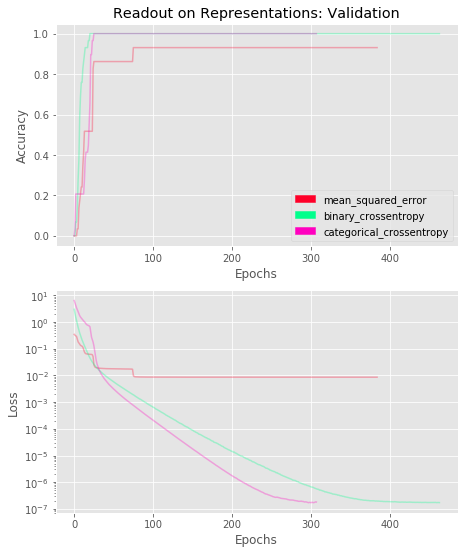

In [223]:
history_repr_losses.plot_acc_loss("Readout on Representations: Validation", "val_")

In [17]:
history_repr_act = AppendedHistory(varname='Activation')

In [18]:
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, restore_best_weights=True)
activations = ['softmax', 'sigmoid']
for activation in activations:
    print('activation = {}'.format(activation))
    readout = build_readout(activation=activation)
    history = readout.fit(cl_x_train_in, cl_x_train_out, \
                            epochs=500, \
                            batch_size=1, \
                            shuffle=True, \
                            validation_data=(cl_x_test_in, cl_x_test_out), \
                            verbose=0, callbacks=[callback])
    history.history['acc'] = history.history.pop('categorical_accuracy')
    history.history['val_acc'] = history.history.pop('val_categorical_accuracy')
    history_repr_act.append_hist(activation, history)
    readout.save('data/incite/models_log/readout/ro_repr_act_{}'.format(activation))

activation = softmax
activation = sigmoid


In [19]:
history_repr_act.save('data/incite/models_log/readout/history_repr_act')

In [29]:
history_repr_act = AppendedHistory(fname='data/incite/models_log/readout/history_repr_act')

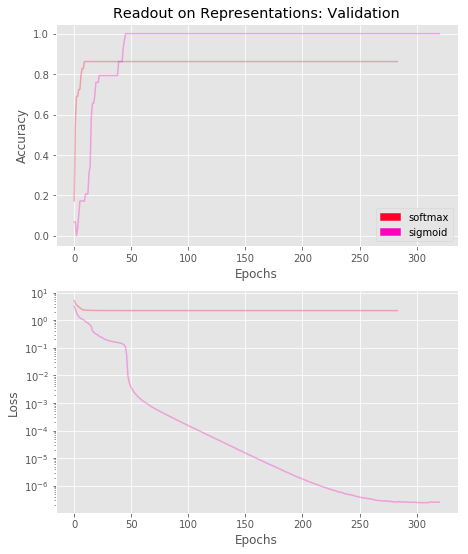

In [31]:
history_repr_act.plot_acc_loss("Readout on Representations: Validation", "val_")

In [34]:
history_repr_hid = AppendedHistory(varname='num_hid')

In [36]:
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, restore_best_weights=True)
for num_hid in range(5):
    print('num_hid = {}'.format(num_hid))
    readout = build_readout(num_hid=num_hid)
    history = readout.fit(cl_x_train_in, cl_x_train_out, \
                            epochs=500, \
                            batch_size=1, \
                            shuffle=True, \
                            validation_data=(cl_x_test_in, cl_x_test_out), \
                            verbose=0, callbacks=[callback])
    history.history['acc'] = history.history.pop('categorical_accuracy')
    history.history['val_acc'] = history.history.pop('val_categorical_accuracy')
    history_repr_hid.append_hist(num_hid, history)
    readout.save('data/incite/models_log/readout/ro_repr_num_hid_{}'.format(num_hid))

num_hid = 0
num_hid = 1
num_hid = 2
num_hid = 3
num_hid = 4


In [42]:
history_repr_hid.save('data/incite/models_log/readout/history_repr_hid')

In [43]:
history_repr_hid = AppendedHistory(fname='data/incite/models_log/readout/history_repr_hid')

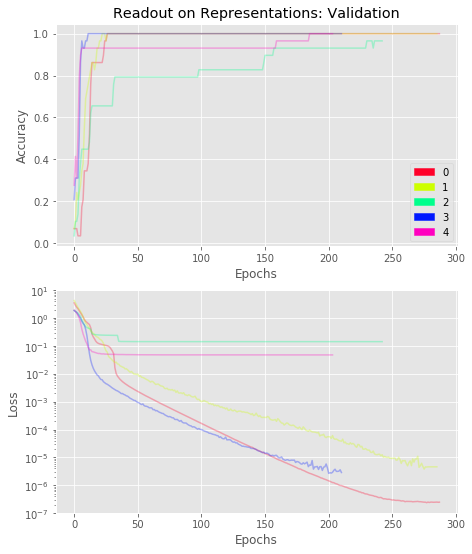

In [44]:
history_repr_hid.plot_acc_loss("Readout on Representations: Validation", "val_")

In [49]:
load_model('data/incite/models_log/readout/ro_repr_num_hid_3').evaluate(cl_x_test_in, cl_x_test_out, batch_size=1)

29/29 [==============================] - 0s 8ms/step


[2.6699332899962145e-06, 1.0]

### Custom Training

#### Input <a class="anchor" id="repr_data_in"></a>

In [289]:
with open('data/input/x_train.pkl', 'rb') as f:
    x_train = pkl.load(f)
with open('data/input/x_test.pkl', 'rb') as f:
    x_test = pkl.load(f)

In [256]:
simple_nonsp = 'data/incite/models_log/ae/simple/encoder_3'
simple_sp = 'data/incite/models_log/ae/simple/sparse/best/encoder_sp_1e-05_1'
deep_dn = 'data/incite/models_log/ae/denoising/dn_encoder_num-hid_4_bs_32'
deep_1 = 'data/incite/models_log/ae/deep/deep_encoder_num-hid_1'
deep_3 = 'data/incite/models_log/ae/deep/deep_encoder_num-hid_3'

In [299]:
encoder = load_model(simple_nonsp)
cl_x_train_in = encoder.predict(x_train)
cl_x_test_in = encoder.predict(x_test)

/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


#### Training

In [298]:
history_repr = AppendedHistory(varname='num_hid')

In [300]:
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, restore_best_weights=True)
for i in [0, 3]:
    print('num_hid = {}'.format(i))
    readout = build_readout(num_hid=i)
    %time history = readout.fit(cl_x_train_in, cl_x_train_out, \
                            epochs=400, \
                            batch_size=1, \
                            shuffle=True, \
                            validation_data=(cl_x_test_in, cl_x_test_out), \
                            verbose=0, callbacks=[callback])
    history.history['acc'] = history.history.pop('categorical_accuracy')
    history.history['val_acc'] = history.history.pop('val_categorical_accuracy')
    history_repr.append_hist(i, history)
    readout.save('data/incite/models_log/readout/nonsp/ro_repr_num_hid_{}'.format(i))

num_hid = 0
CPU times: user 1min 2s, sys: 11.9 s, total: 1min 14s
Wall time: 46.7 s
num_hid = 3
CPU times: user 1min 4s, sys: 16.7 s, total: 1min 20s
Wall time: 46.8 s


In [301]:
history_repr.save('data/incite/models_log/readout/nonsp/ro_repr_num_hid')

In [302]:
history_repr = AppendedHistory(fname='data/incite/models_log/readout/nonsp/ro_repr_num_hid')

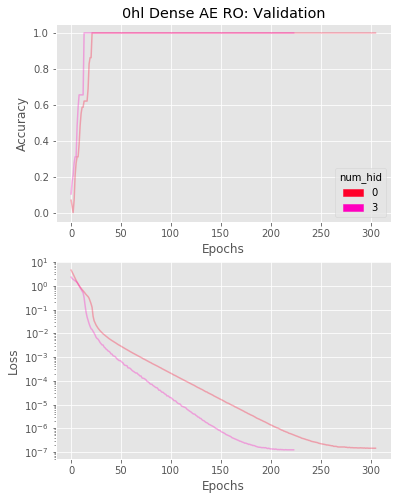

In [303]:
history_repr.plot_acc_loss("0hl Dense AE RO: Validation", "val_", log=True)#, save=True, fname='0hl_sp_ae_ro_val.pdf')

In [304]:
load_model('data/incite/models_log/readout/nonsp/ro_repr_num_hid_0').evaluate(cl_x_test_in, cl_x_test_out, batch_size=1)

29/29 [==============================] - 0s 9ms/step


[1.4387328735273482e-07, 1.0]

### Comparison <a class="anchor" id="comparison"></a>

In [145]:
with open('data/input/times_xz.pkl', 'rb') as f:
    times_xz = pkl.load(f)
with open('data/input/batches_200.pkl', 'rb') as f:
    batches_200 = pkl.load(f)
with open('data/input/GID_to_num.pkl', 'rb') as f:
    GID_to_num = pkl.load(f)

In [240]:
ro_in = load_model('data/incite/models_log/readout/ro_in_4')
ro_in.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 2170)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 17368     
Total params: 17,368
Trainable params: 17,368
Non-trainable params: 0
_________________________________________________________________


In [272]:
def get_ro_in(ro_in, x_test_out, times_xz=times_xz, \
              batches_200=batches_200, GID_to_num=GID_to_num, max_blobs=15, num_rounds=5):
    ls, acs = [], []
    for i in range(max_blobs):
        ls_i, acs_i = [], []
        for j in range(num_rounds):
            data = get_train_test(create_data(missing_blobs=i))[1]
            l, a = ro_in.evaluate(data, x_test_out, batch_size=1, verbose=2)
            ls_i.append(l)
            acs_i.append(a)
        ls.append(np.mean(ls_i))
        acs.append(np.mean(acs_i))
    return ls, acs

In [273]:
def get_ro_repr(ro_repr, encoder, x_test_out, times_xz=times_xz, \
                batches_200=batches_200, GID_to_num=GID_to_num, max_blobs=15, num_rounds=5):
    ls, acs = [], []
    for i in range(max_blobs):
        ls_i, acs_i = [], []
        for j in range(num_rounds):
            data = get_train_test(create_data(missing_blobs=i))[1]
            l, a = ro_repr.evaluate(encoder.predict(data), x_test_out, batch_size=1, verbose=2)
            ls_i.append(l)
            acs_i.append(a)
        ls.append(np.mean(ls_i))
        acs.append(np.mean(acs_i))
    return ls, acs

In [193]:
simple_nonsp = 'data/incite/models_log/ae/simple/encoder_3'
simple_sp = 'data/incite/models_log/ae/simple/sparse/best/encoder_sp_1e-05_1'
deep_dn = 'data/incite/models_log/ae/denoising/dn_encoder_num-hid_4_bs_32'
deep_1 = 'data/incite/models_log/ae/deep/deep_encoder_num-hid_1'
deep_3 = 'data/incite/models_log/ae/deep/deep_encoder_num-hid_3'

In [261]:
encoder = load_model(simple_sp)

/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [310]:
ro_repr_sp_0 = 'data/incite/models_log/readout/ro_repr_num_hid_0' # use with `simple_sp`
ro_repr_sp_3 = 'data/incite/models_log/readout/ro_repr_num_hid_3' # use with `simple_sp`
ro_repr_0 = 'data/incite/models_log/readout/nonsp/ro_repr_num_hid_0' # use with `simple_nonsp`
ro_repr_3 = 'data/incite/models_log/readout/nonsp/ro_repr_num_hid_3' # use with `simple_nonsp`

ro_repr = load_model(ro_repr_3)
ro_repr.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 72        
Total params: 288
Trainable params: 288
Non-trainable params: 0
_________________________________________________________________


In [306]:
%time ls_in, acs_in = get_ro_in(ro_in, cl_x_test_out, num_rounds=100)

CPU times: user 1min 12s, sys: 3.5 s, total: 1min 16s
Wall time: 1min 8s


In [311]:
%time ls_repr, acs_repr = get_ro_repr(ro_repr, encoder, cl_x_test_out, num_rounds=100)

CPU times: user 1min 16s, sys: 5.08 s, total: 1min 21s
Wall time: 1min 11s


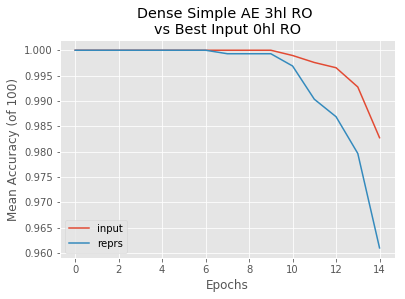

In [312]:
with plt.style.context('ggplot'):
    plt.plot(acs_in, label='input')
    plt.plot(acs_repr, label='reprs')
    plt.legend()
    plt.title('Dense Simple AE 3hl RO \nvs Best Input 0hl RO')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Accuracy (of 100)')
    plt.savefig('data/incite/models_log/readout/pics/new/acc_ds-ae-ro-3hl_vs_in_0hl_ro__100.pdf', dpi=300)
plt.show()

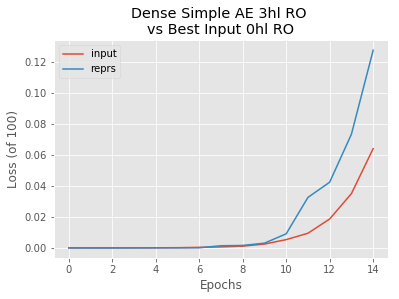

In [313]:
with plt.style.context('ggplot'):
    plt.plot(ls_in, label='input')
    plt.plot(ls_repr, label='reprs')
    plt.legend()
    plt.title('Dense Simple AE 3hl RO \nvs Best Input 0hl RO')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (of 100)')
    plt.savefig('data/incite/models_log/readout/pics/new/loss_ds-ae-ro-3hl_vs_in_0hl_ro__100.pdf', dpi=300)
plt.show()

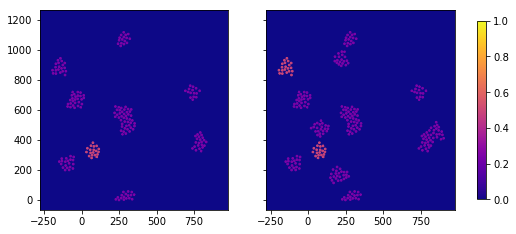

In [315]:
plot([get_train_test(create_data(times_xz, batches_200, GID_to_num, 5))[0][57], x_train[57]], show=True, \
     save=True, plot_name='pic.pdf')

# Analysis <a class="anchor" id="analysis"></a>
## Analytical Tools Development <a class="anchor" id="analytical-tools-development"></a>
### Comparative Histogram <a class="anchor" id="comparative-histogram"></a>
Here, I use the best [Simple Autoencoder](#simple-autoencoder) model.

`decoded` vs `x_test` distributions for each test vector.

In [64]:
with open('data/input/x_train.pkl', 'rb') as f:
    x_train = pkl.load(f)
with open('data/input/x_test.pkl', 'rb') as f:
    x_test = pkl.load(f)
x_data = np.vstack((x_train, x_test))

In [67]:
autoencoder = load_model('data/incite/models_log/ae/simple/autoencoder_3')

In [68]:
decoded_sl = autoencoder.predict(x_test)

In [69]:
autoencoder = load_model('data/incite/models_log/ae/simple/sparse/best/autoencoder_sp_1e-05_0')

In [70]:
decoded_sp = autoencoder.predict(x_test)

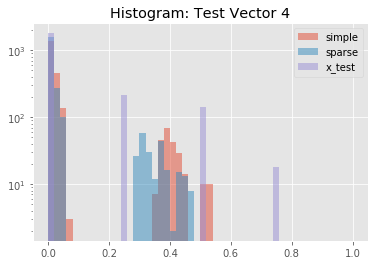

In [72]:
i = 4 # Insert i from 0 to 28.
with plt.style.context('ggplot'):
    plt.hist(decoded_sl[i], log=True, bins=50, range=[0, 1], alpha=0.5, label='simple')
    plt.hist(decoded_sp[i], log=True, bins=50, range=[0, 1], alpha=0.5, label='sparse')
    plt.hist(x_test[i], log=True, bins=50, range=[0, 1], alpha=0.5, label='x_test')
    plt.title("Histogram: Test Vector {}".format(i))
    plt.legend()
plt.show()

In [65]:
def get_comp_hist(fnames, folder, labels=None):
    if labels == None:
        labels = ["decoded_{}".format(i) for i in range(len(fnames))]
    with plt.style.context('ggplot'):
        decodeds = []
        for fname in fnames:
            autoencoder = load_model(fname)
            decoded = autoencoder.predict(x_test)
            decodeds.append(decoded)
        for test_num in range(x_test.shape[0]):
            for decoded, label in zip(decodeds, labels):
                plt.hist(decoded[test_num], log=True, bins=50, range=[0, 1], alpha=0.5, label=label)
            plt.hist(x_test[test_num], log=True, bins=50, range=[0, 1], alpha=0.5, label='x_test')
            plt.title("Histogram: Test Vector {}".format(test_num))
            plt.legend()
            plt.savefig('{}comp_hist_{}.pdf'.format(folder, test_num), dpi=300)
            plt.clf()

As we see in the histogram, the values of the decoded images form 2 "groups", not 4 (like the input):
- close to 0,
- somewhere in between 0.2-0.6 (different for different patterns).

Seems like the autoencoder only differentiates between "most probably shouldn't be active" and "might be active".

Note that this kind of distribution is more or less what we should get due to the initial probabilistic approach.

In [73]:
print("decoded_sl - max value: {}".format(np.max(np.abs(decoded_sl))))
print("decoded_sp - max value: {}".format(np.max(np.abs(decoded_sp))))
print("max abs difference:      {}".format(np.max(np.abs(decoded_sl - decoded_sp))))

decoded_sl - max value: 0.6490247845649719
decoded_sp - max value: 0.6418477892875671
max abs difference:      0.2439350187778473


### Comparative Animation <a class="anchor" id="comparative-animation"></a>

Visualization of `decoded` vs `x_test` by taking one test vector at a time.

In [77]:
plot([decoded_sl, x_test], ['Decoded', 'Test'], 'Simple AE', 'comparison_sl', scale_to_01=False)

### Working with Patterns <a class="anchor" id="working-with-patterns"></a>

In [82]:
with open('data/input/stim_train.pkl', 'rb') as f:
    stim_train = pkl.load(f)

In [83]:
# `d_data` - dictionary of all indices of each pattern, dict.
d_data = {}
for i in np.unique(stim_train):
    d_data[i] = np.argwhere(stim_train == i).reshape(-1)

In [84]:
d_data

{205315: array([  3,  16,  17,  40,  48,  50,  51,  55,  81,  84,  86,  90,  91,
        101, 104, 132, 144]),
 249980: array([  0,   5,   9,  11,  22,  29,  46,  56,  70,  77,  89, 105, 109,
        127, 130, 134, 137, 138, 142]),
 397555: array([  1,   4,   7,  10,  27,  31,  35,  44,  45,  61,  63,  69,  96,
        100, 102, 103, 107, 139, 143]),
 446691: array([  2,  14,  30,  38,  49,  52,  54,  59,  68,  71,  74,  95, 112,
        116, 117, 120, 121, 129, 133]),
 515018: array([ 19,  23,  26,  43,  47,  57,  65,  72,  73,  75,  78,  83,  92,
         94,  99, 119, 126, 140]),
 740558: array([  8,  13,  20,  21,  25,  28,  37,  41,  53,  66,  82,  85,  88,
         93, 106, 123, 124]),
 757795: array([  6,  24,  32,  34,  42,  60,  62,  64,  67,  79,  97, 108, 110,
        113, 118, 128, 136, 141]),
 766947: array([ 12,  15,  18,  33,  36,  39,  58,  76,  80,  87,  98, 111, 114,
        115, 122, 125, 131, 135])}

In [85]:
d_train = {key: d_data[key][np.where(d_data[key] < 116)] for key in d_data.keys()}

In [86]:
d_test = {key: d_data[key][np.where(d_data[key] >= 116)]-116 for key in d_data.keys()}

#### Pattern Sums  <a class="anchor" id="pattern-sums"></a>

In [87]:
# `sums` - normalized sums of the activations of all instances of each pattern, list of 1darrays.
def get_sums(d_data, x_data):
    sums = []
    for key in d_data.keys():
        sum_ = x_data[d_data[key][0]]
        for i in d_data[key][1:]:
            sum_ = sum_ + x_data[i]
        sum_ = sum_ / np.max(sum_)
        sums.append(sum_)
    return sums

In [88]:
sums = get_sums(d_data, x_data)

In [ ]:
for i, key in enumerate(d_data.keys()):
    plot([sums[i]], ['Pattern {}: Input Sum'.format(str(key))], '', 'models_log/shuffle/pattern_sums_input/pattern_sum_{}.pdf'.format(key))

In [71]:
sums_decoded = get_sums(d_test, decoded_100)

In [ ]:
for i, key in enumerate(d_data.keys()):
    plot([sums_decoded[i]], ['Pattern {}: Decoded Sum'.format(str(key))], '', 'models_log/shuffle/pattern_sums_decoded/pattern_sum_{}.pdf'.format(key))

#### Patterns Distributions <a class="anchor" id="pattern-distributions"></a>

In [31]:
encoder = load_model('data/incite/models_log/ae/simple/encoder_3')

/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
encoded_imgs = encoder.predict(x_test)

In [117]:
# `distribs` - distributions of encoded representations for each test pattern, list of 1darrays.
def get_distribs(encoded_imgs):
    distribs = []
    for key in d_test.keys():
        distrib = []
        for i in d_test[key]:
            distrib.append(encoded_imgs[i])
        distrib = np.array(distrib)
        distribs.append(distrib)
    return distribs

In [118]:
def plot_distribs(distribs, title='', add='', rfolder='ae/simple/pattern_distribs/'):
    with plt.style.context('ggplot'):
        for i, key in enumerate(d_test.keys()):
            fig, ax = plt.subplots(figsize=(6, 4))
            ax.set_ylim(0, 20)
            for distrib in distribs[i]:
                arr = np.vstack((np.arange(8)+1, distrib)).T
                ax.scatter(arr[:, 0], arr[:, 1], alpha=0.7)
            ax.set_title("{}Pattern {}".format(title, key))
            fig.savefig("data/incite/models_log/{}pattern_distrib_{}{}.pdf".format(rfolder, key, add), dpi=300)

In [119]:
plot_distribs(get_distribs(encoded_imgs), title='Simple AE: ', add='')

/Users/utanashati/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [127]:
def plot_error_distribs(encoder, times_xz=times_xz, \
                        batches_200=batches_200, GID_to_num=GID_to_num, max_blobs=15):
    for i in range(max_blobs):
        data = get_train_test(create_data(missing_blobs=i))[1]
        encoded_imgs = encoder.predict(data)
        plot_distribs(get_distribs(encoded_imgs), title='W/o {} blobs: '.format(i), \
                      add='_ec_{}'.format(i), rfolder='ae/simple/pattern_distribs_ec/')

In [128]:
plot_error_distribs(encoder)

/Users/utanashati/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


#### Summary Table <a class="anchor" id="summary-table"></a>

446691 | 757795 | 766947
--- | --- | ---
<img src="data/incite/models_log/shuffle/pattern_sums_decoded/pattern_sum_446691.png" /> | <img src="data/incite/models_log/shuffle/pattern_sums_decoded/pattern_sum_757795.png" /> | <img src="data/incite/models_log/shuffle/pattern_sums_decoded/pattern_sum_766947.png" />
<img src="data/incite/models_log/shuffle/pattern_sums_input/pattern_sum_446691.png" /> | <img src="data/incite/models_log/shuffle/pattern_sums_input/pattern_sum_757795.png" /> | <img src="data/incite/models_log/shuffle/pattern_sums_input/pattern_sum_766947.png" />
<img src="data/incite/models_log/shuffle/pattern_distribs/pattern_distrib_446691.png" /> | <img src="data/incite/models_log/shuffle/pattern_distribs/pattern_distrib_757795.png" /> | <img src="data/incite/models_log/shuffle/pattern_distribs/pattern_distrib_766947.png" />

### Dimensional Representation Visualization <a class="anchor" id="dim-repr-viz"></a>

In [4]:
with open('data/input/x_test.pkl', 'rb') as f:
    x_test = pkl.load(f)

In [69]:
encoder = load_model('data/incite/models_log/shuffle/encoder_100eps_true_0')
decoder = load_model('data/incite/models_log/shuffle/decoder_100eps_true_0')

/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [70]:
encoded = encoder.predict(x_test)
decoded = decoder.predict(encoded)

In [ ]:
for j in range(x_test.shape[0]):
    plot([decoded[j]], \
         ['Decoded', 'Original'], 'Test Vector {}'.format(j), \
         "models_log/shuffle/dim_viz/vect_{}_comparison.pdf".format(j))

In [97]:
decoded_new_all_zeros = []
for i in range(encoded.shape[1]):
    encoded_new = np.zeros((encoded.shape[0], encoded.shape[1]))
    encoded_new[:, i] = encoded[:, i]
    decoded_new = decoder.predict(encoded_new)
    decoded_new_all_zeros.append(decoded_new)
decoded_new_all_zeros = np.array(decoded_new_all_zeros)

In [98]:
decoded_new_all_ones = []
for i in range(encoded.shape[1]):
    encoded_new = np.ones((encoded.shape[0], encoded.shape[1]))
    encoded_new[:, i] = encoded[:, i]
    decoded_new = decoder.predict(encoded_new)
    decoded_new_all_ones.append(decoded_new)
decoded_new_all_ones = np.array(decoded_new_all_ones)

In [ ]:
for i in range(encoded.shape[1]):
    for j in [15, 17]:
        plot([decoded_new_all_ones[i, j, :]], \
             ['Representation Dimention {}'.format(i)], \
             '', "models_log/shuffle/dim_viz/{}/vect_{}_repr_only_{}.png".format(j, j, i))

In [ ]:
for i in range(encoded.shape[1]):
    for j in [15, 17]:
        plot([decoded_new_all_zeros[:, j, :], decoded_new_all_ones[:, j, :], \
             [decoded[j]]*encoded.shape[1], [x_test[j]]*encoded.shape[1]], \
             ['Zeros', 'Ones', 'Decoded', 'Original'], \
             'Test Vector {}'.format(j), "models_log/shuffle/dim_viz/{}/vect_{}_reprs".format(j))

#### Example Tables <a class="anchor" id="ex-tables"></a>

| | | Vector 15
--- | --- | --- | ---
<img src="data/incite/models_log/shuffle/dim_viz/15/vect_15_repr_only_0.png" /> | <img src="data/incite/models_log/shuffle/dim_viz/15/vect_15_repr_only_1.png" /> | <img src="data/incite/models_log/shuffle/dim_viz/15/vect_15_repr_only_2.png" /> | <img src="data/incite/models_log/shuffle/dim_viz/15/vect_15_repr_only_3.png" />
<img src="data/incite/models_log/shuffle/dim_viz/15/vect_15_repr_only_4.png" /> | <img src="data/incite/models_log/shuffle/dim_viz/15/vect_15_repr_only_5.png" /> | <img src="data/incite/models_log/shuffle/dim_viz/15/vect_15_repr_only_6.png" /> | <img src="data/incite/models_log/shuffle/dim_viz/15/vect_15_repr_only_7.png" />
<img src="data/incite/models_log/shuffle/dim_viz/15/vect_15_decoded.png" /> | <img src="data/incite/models_log/shuffle/dim_viz/15/vect_15_test.png" />

| | | Vector 17
--- | --- | --- | ---
<img src="data/incite/models_log/shuffle/dim_viz/17/vect_17_repr_only_0.png" /> | <img src="data/incite/models_log/shuffle/dim_viz/17/vect_17_repr_only_1.png" /> | <img src="data/incite/models_log/shuffle/dim_viz/17/vect_17_repr_only_2.png" /> | <img src="data/incite/models_log/shuffle/dim_viz/17/vect_17_repr_only_3.png" />
<img src="data/incite/models_log/shuffle/dim_viz/17/vect_17_repr_only_4.png" /> | <img src="data/incite/models_log/shuffle/dim_viz/17/vect_17_repr_only_5.png" /> | <img src="data/incite/models_log/shuffle/dim_viz/17/vect_17_repr_only_6.png" /> | <img src="data/incite/models_log/shuffle/dim_viz/17/vect_17_repr_only_7.png" />
<img src="data/incite/models_log/shuffle/dim_viz/17/vect_17_decoded.png" /> | <img src="data/incite/models_log/shuffle/dim_viz/17/vect_17_test.png" />

### Weights Visualization <a class="anchor" id="weights-viz"></a>

In [103]:
with open('data/input/x_train.pkl', 'rb') as f:
    x_train = pkl.load(f)
with open('data/input/x_test.pkl', 'rb') as f:
    x_test = pkl.load(f)
x_data = np.vstack((x_train, x_test))

In [104]:
encoder = load_model('data/incite/models_log/shuffle/encoder_100eps_true_0')
decoder = load_model('data/incite/models_log/shuffle/decoder_100eps_true_0')

/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [246]:
for i in range(8):
    plot([encoder.get_weights()[0].T[i]], ['Encoder Weights {}'.format(i)], '', \
         "models_log/shuffle/weights_viz/encoder_weights_{}.pdf".format(i), scale_to_01=False, ticksize=5)

In [247]:
for i in range(8):
    plot([decoder.get_weights()[0][i]], ['Decoder Weights {}'.format(i)], '', \
         "models_log/shuffle/weights_viz/decoder_weights_{}.pdf".format(i), scale_to_01=False, ticksize=5)

In [279]:
# Normalize weights.
d_weights = decoder.get_weights()[0]
d_weights = (d_weights - np.min(d_weights)) / (np.max(d_weights)-np.min(d_weights))

In [255]:
for i, key in enumerate(d_data.keys()):
    mins = np.min(np.abs(d_weights - np.tile(sums[i], (8, 1))), axis=1)
    argmins = mins.argsort()
    plot([sums[i], d_weights[argmins[0]], d_weights[argmins[1]]], \
         ['Sum', 'Decoder Weights {}'.format(argmins[0]), 'Decoder Weights {}'.format(argmins[1])], \
         'Pattern {}'.format(key), \
         "models_log/shuffle/sums_vs_weights_pattern_{}.pdf".format(key))

In [264]:
# Get positive weights, normalize.
d_weights_pos = decoder.get_weights()[0]
d_weights_pos = np.where(d_weights_pos >= 0, d_weights_pos, 0)
d_weights_pos = (d_weights_pos - np.min(d_weights_pos)) / (np.max(d_weights_pos)-np.min(d_weights_pos))

In [276]:
# Get negative weights, normalize.
d_weights_neg = decoder.get_weights()[0]
d_weights_neg = np.where(d_weights_neg < 0, np.abs(d_weights_neg), 0)
d_weights_neg = (d_weights_neg - np.min(d_weights_neg)) / (np.max(d_weights_neg)-np.min(d_weights_neg))

In [349]:
# Plot normalized weights.
for i in range(3, 4):
    plot([d_weights_pos[i], d_weights_neg[i], d_weights[i]], \
         ['Positive', 'Negative', 'All'], \
         'Decoder Weights {}'.format(i), \
         "models_log/shuffle/weights_viz/decoder_weights_compare_{}.png".format(i))

**NB:** For negative weights, the more negative the weight, the brighter the color.

<img src="data/incite/models_log/shuffle/weights_viz/decoder_weights_compare_3.png" />

### Clustering Visualization <a class="anchor" id="clustering-viz"></a>

In [285]:
with open('data/input/x_test.pkl', 'rb') as f:
    x_test = pkl.load(f)

In [286]:
with open('data/input/stim_train.pkl', 'rb') as f:
    stim_train = pkl.load(f)

In [292]:
# `d_data` - dictionary of all indices of each pattern, dict.
d_data = {}
for i in np.unique(stim_train):
    d_data[i] = np.argwhere(stim_train == i).reshape(-1)

In [296]:
d_patt = {key: i for i, key in enumerate(d_data.keys())}

In [301]:
stim_nums = np.array([d_patt[patt_name] for patt_name in stim_train])

In [338]:
encoder = load_model('data/incite/models_log/encdims/encoder_encdim_2_200eps')
decoder = load_model('data/incite/models_log/encdims/decoder_encdim_2_200eps')
encoded = encoder.predict(x_data)

/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


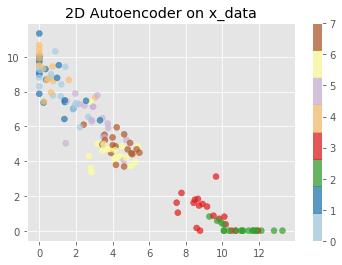

In [339]:
with plt.style.context('ggplot'):
    plt.scatter(encoded[:, 0], encoded[:, 1], c=stim_nums, cmap=plt.cm.get_cmap('Paired', 8), alpha=0.7)
    plt.title('2D Autoencoder on x_data')
    plt.colorbar()
plt.savefig('data/incite/clustering/x_data_2d_ae.pdf', dpi=300)
plt.show()

In [352]:
encoder = load_model('data/incite/models_log/shuffle/encoder_100eps_true_0')
decoder = load_model('data/incite/models_log/shuffle/decoder_100eps_true_0')
encoded = encoder.predict(x_data)

/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [347]:
for i in range(8):
    for j in range(i+1, 8):
        with plt.style.context('ggplot'):
            plt.scatter(encoded[:, i], encoded[:, j], c=stim_nums, cmap=plt.cm.get_cmap('Paired', 8), alpha=0.7)
            plt.title('8D Autoencoder on x_data: {} vs {}'.format(i, j))
            plt.colorbar()
        plt.savefig('data/incite/clustering/x_data_8d_ae_{}_vs_{}.png'.format(i, j), dpi=300)
        plt.close('all')

#### 8D AE Summary Table <a class="anchor" id="8d-ae-table"></a>

1| 2| 3| 4| 5| 6| 7
--- | --- | --- | --- | --- | --- | --- | ---
<img src="data/incite/clustering/x_data_8d_ae_0_vs_1.png" /> | <img src="data/incite/clustering/x_data_8d_ae_0_vs_2.png" /> | <img src="data/incite/clustering/x_data_8d_ae_0_vs_3.png" /> | <img src="data/incite/clustering/x_data_8d_ae_0_vs_4.png" /> | <img src="data/incite/clustering/x_data_8d_ae_0_vs_5.png" /> | <img src="data/incite/clustering/x_data_8d_ae_0_vs_6.png" /> | <img src="data/incite/clustering/x_data_8d_ae_0_vs_7.png" />
| <img src="data/incite/clustering/x_data_8d_ae_1_vs_2.png" /> | <img src="data/incite/clustering/x_data_8d_ae_1_vs_3.png" /> | <img src="data/incite/clustering/x_data_8d_ae_1_vs_4.png" /> | <img src="data/incite/clustering/x_data_8d_ae_1_vs_5.png" /> | <img src="data/incite/clustering/x_data_8d_ae_1_vs_6.png" /> | <img src="data/incite/clustering/x_data_8d_ae_1_vs_7.png" />
|| <img src="data/incite/clustering/x_data_8d_ae_2_vs_3.png" /> | <img src="data/incite/clustering/x_data_8d_ae_2_vs_4.png" /> | <img src="data/incite/clustering/x_data_8d_ae_2_vs_5.png" /> | <img src="data/incite/clustering/x_data_8d_ae_2_vs_6.png" /> | <img src="data/incite/clustering/x_data_8d_ae_2_vs_7.png" />
||| <img src="data/incite/clustering/x_data_8d_ae_3_vs_4.png" /> | <img src="data/incite/clustering/x_data_8d_ae_3_vs_5.png" /> | <img src="data/incite/clustering/x_data_8d_ae_3_vs_6.png" /> | <img src="data/incite/clustering/x_data_8d_ae_3_vs_7.png" />
|||| <img src="data/incite/clustering/x_data_8d_ae_4_vs_5.png" /> | <img src="data/incite/clustering/x_data_8d_ae_4_vs_6.png" /> | <img src="data/incite/clustering/x_data_8d_ae_4_vs_7.png" />
||||| <img src="data/incite/clustering/x_data_8d_ae_5_vs_6.png" /> | <img src="data/incite/clustering/x_data_8d_ae_5_vs_7.png" />
|||||| <img src="data/incite/clustering/x_data_8d_ae_6_vs_7.png" />

In [313]:
import helpers.tsne

In [ ]:
tsned = tsne.tsne(encoded, 2, 8)

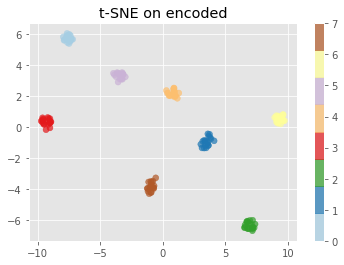

In [357]:
with plt.style.context('ggplot'):
    plt.scatter(tsned[:, 0], tsned[:, 1], c=stim_nums, cmap=plt.cm.get_cmap('Paired', 8), alpha=0.7)
    plt.title("t-SNE on encoded")
    plt.colorbar()
plt.savefig('data/incite/clustering/x_data_8d_to_2d_tsne.pdf', dpi=300)
plt.show()

In [ ]:
tsned = tsne.tsne(x_data, 2)

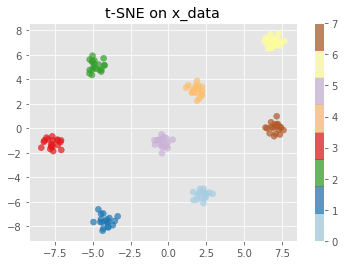

In [335]:
with plt.style.context('ggplot'):
    plt.scatter(tsned[:, 0], tsned[:, 1], c=stim_nums, cmap=plt.cm.get_cmap('Paired', 8), alpha=0.7)
    plt.title("t-SNE on x_data")
    plt.colorbar()
plt.savefig('data/incite/clustering/x_data_2d_tsne.pdf', dpi=300)
plt.show()

#### Project Log <a class="anchor" id="project-log"></a>

**26.10.2018**
- Finished major clean up:
    - Got rid of irrelevant/old code/markdown
        - To make the contents tell a congruent story.
    - Notebook is no more structured by date, reasons being that:
        - I continue to improve what I've done before,
        - I clean up a lot of irrelevant info,
        - Transparent versioning (thx to GitHub) is still there.
- Created a new outline:
    - Each section and most revelant subsections can be loaded independently,
    - Table of contents:
        - Multilevel list,
        - Clickable.
- Modified `AppendedHistory` for the project
    - And used it throughout training (and will continue to use).
- Observed the effect of shuffling before each epoch on the learning process.
    - Visualized the best model.
        - [Comparative Histogram](#comparative-histogram) first done today.

**29.10.2018**
- Switched [Comparative Histogram](#comparative-histogram)'s scale to log.
- Solved the issue with markdown images on GitHub.

**30.10.2018**
- Added [Sparse Autoencoder](#sparse-autoencoder)
- Added `get_comp_hist()` function

**30.10.2018** Meeting
- Train a CNN ?
    - Spatial invariance
- **How do we access that the bio model is learning?**
    - ICE
    - Apply the same principles to autoencoder
- Some neurons become selective to specific stimuli
    - Visualise autoencoder weights ?
- More meaningful metrics
    - R^2
- Sequences
    - Now randomly
    - Might be rules
        - Compare robustness
    - Epochs ?
    - Not the case for now
- **Regular presentations**
    - First pres
        - Intro slides
            - Dataset
            - Problem
- Readout
    - Lower bound on the amount on info present in the system
        - Lower bound nontrivial and high enough => learning happening
    - Classifier/single-layer perceptron on the activity in the circuit
        - Reading out the info that's already there
        - Liquid Computing
            - Linearity is important
        - Acoustic Networks

**Next time:**
- Train a classifier on the representations
    - Pattern completion
        - As remove more and more blobs, trained network will have some degree of robustness
        - Higher bottleneck size will yield results comparable with naive
    - Think of a naive benchmark
        - Compare readout from random (naive) network and trained network
        - Compare readout in the input vs representation layer
- t-SNE on input vs representation layer
- Visualise each dimention
- Visualise autoencoder weights (look up in ANNs miniproject2)
- Representing blobs
    - Try 1-2 epochs, see whether learns blobs

**Not now:**
- Variate bottleneck sizes
- Add an additional layer

**2.11.2018**
- Worked on [Readout/Classifier](#readout).
    - Prepared datasets for classifier training.
    - Trained classifiers with different hidden layer size.